## Unsupervised BGM and soft voting for initial labelling (Score ~ 60.7%) followed by iterative runs of supervised BGM classifier (current best ~81.19%)

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import PowerTransformer
import pylab as pl
from sklego.mixture import BayesianGMMClassifier

In [3]:
n_rows = 98000
n_clusters = 7

known = pd.read_csv("reference_submission.csv", index_col=0).iloc[:, 0].values

data = pd.read_csv('data.csv', index_col=0)
useful_cols = ['f_07','f_08','f_09','f_10','f_11','f_12','f_13',
             'f_22','f_23','f_24','f_25','f_26','f_27','f_28']
data = data[useful_cols]

data = PowerTransformer().fit_transform(data)

In [3]:
all_labels = []
all_probs = []

base = 1301
for seed in tqdm(range(20)):
    np.random.seed(seed + base * 20)
    subspace = data[np.random.random(size=(n_rows,)) < 0.5, :]
 
    gmm = BayesianGaussianMixture(
            n_components = n_clusters,
            random_state = seed + base * 20,
            tol = 0.001,  # Actually, since we're ensembling we might want a higher tol
            max_iter = 200, # and a low max_iter! Because noise is our friend.
            n_init = 4)
    gmm.fit(subspace)

    all_labels.append(gmm.predict(data))
    all_probs.append(gmm.predict_proba(data))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [11:07<00:00, 33.35s/it]


In [4]:
hard_accumulator = np.zeros(shape=(n_rows, n_clusters), dtype=np.int32)
soft_accumulator = np.zeros(shape=(n_rows, n_clusters), dtype=np.float32)
soft_soft_accumulator = np.zeros(shape=(n_rows, n_clusters), dtype=np.float32)

for model_i, labels in enumerate(all_labels):
    probs = all_probs[model_i]
    
    # We create a small n_cluster x n_cluster matrix to store which
    # cluster corresponds to which, compared to the known good clustering.
    clusters = np.zeros(shape = (n_clusters, n_clusters), dtype=int)
    for n1, n2 in zip(labels, known):
        clusters[n1, n2] += 1

    hard_clusters = np.argmax(clusters, axis=1)
    hard_dict = {i: c for i, c in enumerate(hard_clusters)}
    hard_result = np.vectorize(hard_dict.__getitem__)(labels)
    hard_accumulator[np.arange(n_rows), hard_result] += 1
    
    # soft
    soft_clusters = clusters / np.sum(clusters, axis=1).reshape(-1, 1)
    soft_result = soft_clusters[labels]
    soft_accumulator += soft_clusters[labels]

    # extra soft
    soft_soft_accumulator += np.matmul(probs, soft_clusters)

In [5]:
# hard_result = np.argmax(hard_accumulator, axis=1)
# soft_result = np.argmax(soft_accumulator, axis=1)
soft_soft_result = np.argmax(soft_soft_accumulator, axis=1)

pd.DataFrame(soft_soft_result).to_csv('bgm_unsupervised_submission.csv', index_label='Id', header=['Predicted'])

## Supervised BGM classifier using the best predictions

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import BayesianGaussianMixture
from sklego.mixture import BayesianGMMClassifier
from sklearn.preprocessing import PowerTransformer

%matplotlib inline


import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm
import os

import torch.nn.functional as F

In [2]:
data = pd.read_csv("data.csv", index_col='id')
submission = pd.read_csv("sample_submission.csv")

# pred_test = pd.read_csv("bgm_unsupervised_submission.csv", usecols=['Predicted']).values
pred_test = pd.read_csv("bgm_supervised_classifier_soft_voting_fifth_rec.csv", usecols=['Predicted']).values
pred_test = [a.item() for a in pred_test]

known = pd.read_csv("bgm_supervised_classifier_soft_voting_fifth_rec.csv", usecols=['Predicted']).values

useful_cols = ['f_07','f_08','f_09','f_10','f_11','f_12','f_13',
             'f_22','f_23','f_24','f_25','f_26','f_27','f_28']

data = data[useful_cols]
data = PowerTransformer().fit_transform(data)

In [3]:
# Set Static variables
random_state = 2
#n_folds = 10
n_components = 7
verbose = 500
os.environ['PYTHONHASHSEED'] = str(random_state)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
np.random.seed(random_state)
BEST_CLASS_THRESHOLD = 0.87

NUM_EPOCHS = 20
LEARNING_RATE = 1e-2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2000
NUM_WORKERS = 2

In [4]:
X = np.array(data)
y = np.array(pred_test)

In [5]:
all_labels = []
all_probs = []

is_sampling = False
only_cleanest = False

for seed in tqdm(range(10)):
    np.random.seed(seed * 31 + 37 )
    bgm = BayesianGMMClassifier(
        n_components=7,
        random_state = seed,
        tol =3e-4,
        covariance_type = 'full',
        max_iter = 300,
        n_init=3,
        init_params='k-means++'
    )
    
    if is_sampling:
        p = 0.6
        mask = np.random.choice(a=[True, False], size=len(y), p=[p, 1-p])
        sampled_X = X[mask]
        sampled_y = y[mask]
        
    if only_cleanest:
        clean_X = X[cleanest_samples]
        clean_y = y[cleanest_samples]

    # fitting and probability prediction
    bgm.fit(X, y)
    all_labels.append(bgm.predict(X))
    all_probs.append(bgm.predict_proba(X))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:56<00:00, 47.68s/it]


In [6]:
class LinearLayer(nn.Module):
    def __init__(self, in_neurons, out_neurons):
        super().__init__()
        self.linear = nn.Linear(in_neurons, out_neurons)
        self.do = nn.Dropout(p=0.2)
        self.bn = nn.BatchNorm1d(out_neurons)
        self.act = nn.PReLU()
        
    def forward(self, x):
        return self.bn(self.act(self.do(self.linear(x))))
        

class NetClassifier(nn.Module):
    def __init__(self, in_neurons, hidden_neurons, out_neurons):
        super().__init__()
        
        self.hidden_layers = len(hidden_neurons)
          
        self.net = nn.Sequential(
            LinearLayer(in_neurons, hidden_neurons[0]),
            *[LinearLayer(hn, hidden_neurons[i+1]) for i, hn in enumerate(hidden_neurons[:-1])],
            nn.Linear(hidden_neurons[-1], out_neurons),
        )

    def forward(self, x):
        return self.net(x)
    
    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight.data)
            
            
class MyDataset(Dataset):
    def __init__(self, X, y):
        super(MyDataset, self).__init__()
        self.y = y
        self.X = np.float32(X)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [38]:
def train_fn(train_loader, model, opt, criterion):
    train_losses = []
    loop = tqdm(train_loader, leave=True)
    for x, y in loop:
        x = x.to(DEVICE)
        y = y.type(torch.LongTensor).to(DEVICE)
        pred = model(x)
        train_loss = criterion(pred, y)
        loop.set_postfix(L_train=train_loss.item())
        train_losses.append(train_loss.item())
        train_loss.backward()
        opt.step()
        opt.zero_grad()

dataset = MyDataset(X, y)

train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

model = NetClassifier(len(useful_cols), hidden_neurons=[400, 200, 100], out_neurons=n_components).to(DEVICE)
initialize_weights(model)

opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

model.train()

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"{epoch}/{NUM_EPOCHS}")
    train_fn(train_loader, model, opt, criterion)

1/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 44.15it/s, L_train=0.514]


2/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 44.15it/s, L_train=0.452]


3/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 44.54it/s, L_train=0.439]


4/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 42.61it/s, L_train=0.416]


5/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 44.95it/s, L_train=0.377]


6/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 44.55it/s, L_train=0.359]


7/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 41.19it/s, L_train=0.359]


8/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 44.95it/s, L_train=0.353]


9/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 45.21it/s, L_train=0.302]


10/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 45.80it/s, L_train=0.348]


11/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 45.71it/s, L_train=0.282]


12/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 46.52it/s, L_train=0.303]


13/20


100%|████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 43.50it/s, L_train=0.31]


14/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 43.75it/s, L_train=0.318]


15/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 42.41it/s, L_train=0.293]


16/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 41.71it/s, L_train=0.301]


17/20


100%|████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 43.96it/s, L_train=0.29]


18/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 44.34it/s, L_train=0.292]


19/20


100%|███████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 45.24it/s, L_train=0.282]


20/20


100%|████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 44.15it/s, L_train=0.28]


In [39]:
model.eval()
model = model.to("cpu")
test = torch.tensor(X, dtype=torch.float32).to("cpu")
output = F.softmax(model(test), dim=1)
net_probs = output.cpu().detach().numpy()
print(net_probs)

[[9.9089032e-01 1.3145228e-04 5.4597496e-03 ... 2.2047823e-03
  4.3425339e-04 3.5180045e-05]
 [3.2901572e-04 1.1936335e-03 9.5938474e-01 ... 8.8027584e-05
  1.2186040e-02 1.5376454e-02]
 [2.3112677e-01 8.9340232e-05 3.7147591e-05 ... 7.6863921e-01
  1.1304912e-06 1.0814288e-05]
 ...
 [4.7953958e-03 8.1950545e-02 4.7498502e-02 ... 8.5627925e-01
  2.3144765e-03 6.7678690e-03]
 [9.6684889e-05 1.4135185e-04 4.4045296e-02 ... 6.1040218e-03
  2.4680558e-03 2.9375053e-03]
 [1.3246571e-02 3.5887833e-06 7.6908131e-05 ... 8.4112150e-07
  9.7469610e-01 6.1745604e-06]]


In [7]:
n_rows = len(data)
n_clusters = 7

hard_accumulator = np.zeros(shape=(n_rows, n_clusters), dtype=np.int32)
soft_accumulator = np.zeros(shape=(n_rows, n_clusters), dtype=np.float32)
soft_soft_accumulator = np.zeros(shape=(n_rows, n_clusters), dtype=np.float32)

for model_i, labels in enumerate(all_labels):
    probs = all_probs[model_i]
    
    # We create a small n_cluster x n_cluster matrix to store which
    # cluster corresponds to which, compared to the known good clustering.
    clusters = np.zeros(shape = (n_clusters, n_clusters), dtype=int)
    for n1, n2 in zip(labels, known):
        clusters[n1, n2] += 1

    hard_clusters = np.argmax(clusters, axis=1)
    hard_dict = {i: c for i, c in enumerate(hard_clusters)}
    hard_result = np.vectorize(hard_dict.__getitem__)(labels)
    hard_accumulator[np.arange(n_rows), hard_result] += 1
    
    # soft
    soft_clusters = clusters / np.sum(clusters, axis=1).reshape(-1, 1)
    soft_result = soft_clusters[labels]
    soft_accumulator += soft_clusters[labels]

    # extra soft
    soft_soft_accumulator += np.matmul(probs, soft_clusters)

In [43]:
combined_probs = np.array([soft_soft_accumulator/7, net_probs])
mean_probs = np.mean(combined_probs, axis=0)
predict = np.argmax(mean_probs, axis=1)
print(combined_labels.shape)

(98000,)


In [8]:
predict = np.argmax(soft_soft_accumulator, axis=1)

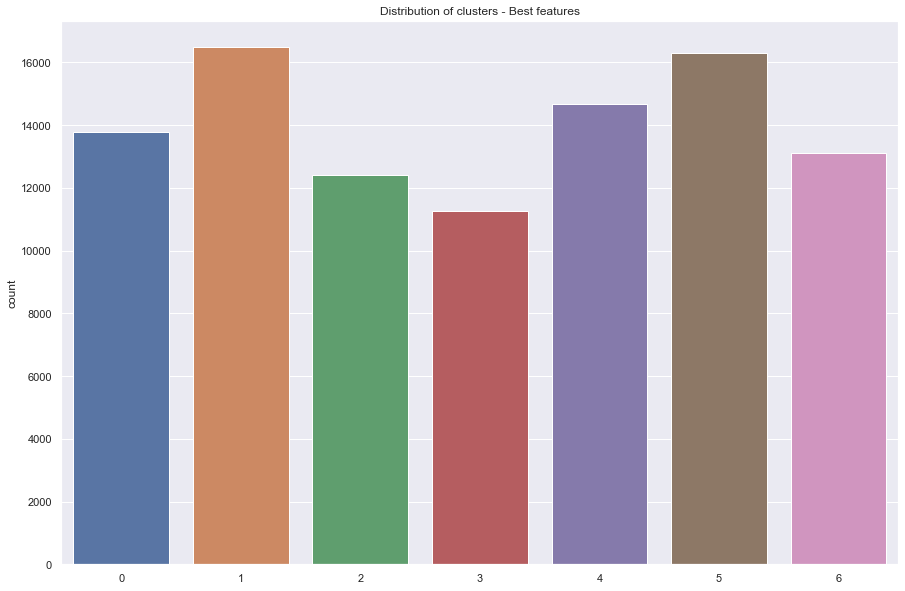

In [9]:
sns.set(rc={'figure.figsize':(15,10)})
pl = sns.countplot(x=predict)
pl.set_title("Distribution of clusters - Best features")
plt.show()

In [10]:
submission['Predicted'] = predict
submission.to_csv('bgm_supervised_soft_voting_sixth_rec.csv', index=False)
submission.head(20)

,Id,Predicted
0,0,0
1,1,2
2,2,4
3,3,6
4,4,1
5,5,1
6,6,6
7,7,0
8,8,2
9,9,5


In [11]:
best = pd.read_csv("bgm_supervised_classifier_soft_voting_fifth_rec.csv", usecols=['Predicted']).values
actual = submission['Predicted'].values

same = 0
notsame = 0
for a, b in zip(best, actual):
    if a==b:
        same+=1
    else:
        notsame+=1
        
print(f"Same: {same} - Diversi: {notsame}")

Same: 97695 - Diversi: 305
